In [2]:
import sumolib
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

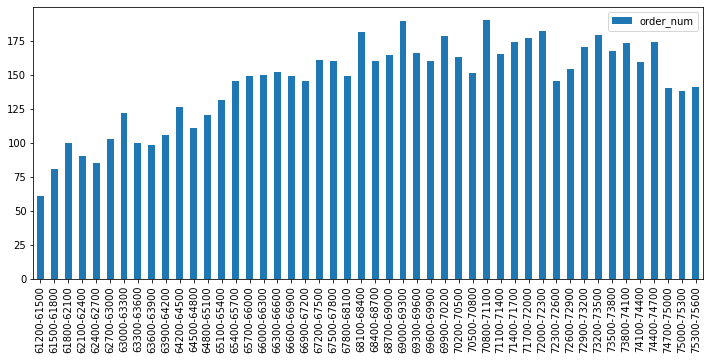

In [3]:
'''订单数量绘图'''
#读取订单数据
data=pd.read_csv(r'persondemand0107\24h0107_end.csv')
#计算任意时段订单量
data=data.loc[:,['pickup_datetime']]
def get_order_num(data,time_interval):
    now=0
    spantime=time_interval
    order_num={}
    while(time_interval<=86400):
        df=data.loc[(data['pickup_datetime']>=now)&(data['pickup_datetime']<time_interval)].count()
        order_num[str(now)+'-'+str(time_interval)]=df[0]
        time_interval+=spantime
        now+=spantime
        
        # print(df)
    return order_num
order_num=get_order_num(data,5*60)
order_date=pd.DataFrame(index=order_num.keys(),data=order_num.values(),columns=['order_num'])
# order_date=pd.DataFrame(index=[i for i in range(24)],data=order_num.values(),columns=['order_num'])

order_date[17*12:21*12].plot(kind='bar',figsize=(12,5))
# order_date.plot()

<AxesSubplot:>

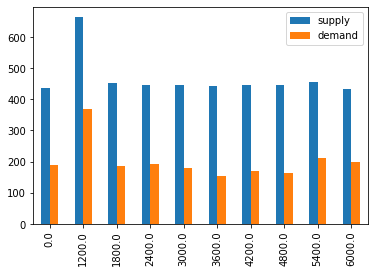

In [4]:
'''供需波动绘图'''
demand_list=[]
supply_list=[]
time_list=[]
for regiondemandsupply in sumolib.xml.parse(r'4.16.1\mylogs\each_region_demand_supply_aggregate.xml',['regiondemandsupply']):
    demand=0
    supply=0
    
    starttime=regiondemandsupply.startTime
    time_list.append(starttime)
    for i in regiondemandsupply.region:
        demand+=int(i.demand)
        supply+=int(i.supply)
    demand_list.append(demand)
    supply_list.append(supply)
# print(time_list,supply_list,demand_list)
df1=pd.DataFrame(index=time_list,data={'supply':supply_list,'demand':demand_list})
df1.plot(kind='bar')

<AxesSubplot:>

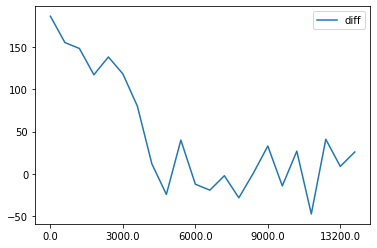

In [6]:
'''供需差异绘图'''
diff_list=[]
time_list=[]
for regiondemandsupply in sumolib.xml.parse(r'base300\mylogs\each_region_demand_supply_aggregate.xml',['regiondemandsupply']):
    diff=0
    starttime=regiondemandsupply.startTime
    time_list.append(starttime)
    for i in regiondemandsupply.region:
        diff+=int(i.supply)-int(i.demand)
    diff_list.append(diff)
# print(time_list,diff_list)
df2=pd.DataFrame(index=time_list,data={'diff':diff_list})
df2.plot()

<AxesSubplot:>

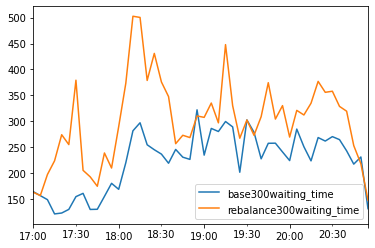

In [7]:
'''调度前后等待时间差异绘图'''
# time_list=[]
import sumolib
import pandas as pd
def waiting_time_mean(file):
    waiting_time_list=[]
    outtime_list=[]
    ordertime_list=[]
    for ride in sumolib.xml.parse(f'{file}/sumo_outputs/tripinfos.xml',['ride']):
        if ride.depart!='-1' and float(ride.depart)<14400:
            ordertime_list.append(float(ride.depart)-float(ride.waitingTime))
            waiting_time_list.append(float(ride.waitingTime))
    df3=pd.DataFrame(index=ordertime_list,data={f'{file}waiting_time':waiting_time_list})
    df3.sort_index(inplace=True)
    df3.index=pd.to_datetime(df3.index,unit='s')
    df3.index=df3.index+pd.Timedelta(hours=17)
    df3.index='2015-01-11 '+df3.index.strftime('%H:%M:%S')
    # df3.index=pd.to_datetime(df3.index,unit='s')
    df3.index=pd.DatetimeIndex(df3.index)
    df4=df3.resample('5T').mean()
    # df4.plot()
    return df4
df41=waiting_time_mean('base300')
# df42=waiting_time_mean('4.14.2')
df43=waiting_time_mean('rebalance300')
df4=pd.concat([df41,df43],axis=1)
df4.plot()
# del df41,df42,df43,df4

In [ ]:
'''调度前后等待时间差异绘图'''
# time_list=[]
import sumolib
import pandas as pd
def waiting_time_mean(file):
    waiting_time_list=[]
    outtime_list=[]
    ordertime_list=[]
    for ride in sumolib.xml.parse(f'{file}/sumo_outputs/tripinfos.xml',['ride']):
        if ride.depart!='-1':
            ordertime_list.append(float(ride.depart)-float(ride.waitingTime))
            waiting_time_list.append(float(ride.waitingTime))
    df3=pd.DataFrame(index=ordertime_list,data={f'{file}waiting_time':waiting_time_list})
    df3.sort_index(inplace=True)
    df3.index=pd.to_datetime(df3.index,unit='s')
    df3.index=df3.index+pd.Timedelta(hours=17)
    df3.index='2015-01-11 '+df3.index.strftime('%H:%M:%S')
    # df3.index=pd.to_datetime(df3.index,unit='s')
    df3.index=pd.DatetimeIndex(df3.index)
    df4=df3.resample('10T').mean()
    return df4
df41=waiting_time_mean('4.14.1')
df42=waiting_time_mean('4.14.2')
df43=waiting_time_mean('4.14.3')

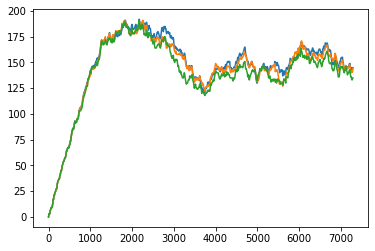

In [18]:
'''任意时间点未完成的订单数'''
import sumolib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
tree=ET.parse(r'4.14.1\sumo_outputs\tripinfos.xml')
root=tree.getroot()
personinfos=root.findall('personinfo')
def count_order(nowtime):
    count=0  
    for personinfo in personinfos:
        if personinfo.findall('ride'): 
            for ride in personinfo.findall('ride'):
                if float(personinfo.get('depart'))<=nowtime and float(ride.get('arrival'))>nowtime:
                    count+=1
        # root.remove(personinfo)
    # print(count)
    return count
# count_order(700)
# unover_order_count=[count_order(i) for i in range(0,7300,10)]
unover_order_count=dict(zip(range(0,7300,10),[count_order(i) for i in range(0,7300,5)]))
unover_order_count
plt.plot(unover_order_count.keys(),unover_order_count.values())
tree=ET.parse(r'4.14.2\sumo_outputs\tripinfos.xml')
root=tree.getroot()
personinfos=root.findall('personinfo')
def count_order(nowtime):
    count=0  
    for personinfo in personinfos:
        if personinfo.findall('ride'): 
            for ride in personinfo.findall('ride'):
                if float(personinfo.get('depart'))<=nowtime and float(ride.get('arrival'))>nowtime:
                    count+=1
        # root.remove(personinfo)
    # print(count)
    return count
# count_order(700)
# unover_order_count=[count_order(i) for i in range(0,7300,10)]
unover_order_count=dict(zip(range(0,7300,10),[count_order(i) for i in range(0,7300,5)]))
# unover_order_count
plt.plot(unover_order_count.keys(),unover_order_count.values())
tree=ET.parse(r'4.14.3\sumo_outputs\tripinfos.xml')
root=tree.getroot()
personinfos=root.findall('personinfo')
def count_order(nowtime):
    count=0  
    for personinfo in personinfos:
        if personinfo.findall('ride'): 
            for ride in personinfo.findall('ride'):
                if float(personinfo.get('depart'))<=nowtime and float(ride.get('arrival'))>nowtime:
                    count+=1
        # root.remove(personinfo)
    # print(count)
    return count
# count_order(700)
# unover_order_count=[count_order(i) for i in range(0,7300,10)]
unover_order_count=dict(zip(range(0,7300,10),[count_order(i) for i in range(0,7300,5)]))
# unover_order_count
plt.plot(unover_order_count.keys(),unover_order_count.values())

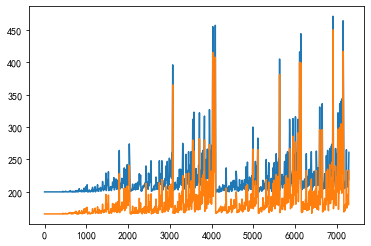

In [48]:
tree=ET.parse(r'4.14.1\sumo_outputs\tripinfos.xml')
root=tree.getroot()
personinfos=root.findall('personinfo')
def count_order(personinfos,nowtime):
    count=0  
    for personinfo in personinfos:
        if personinfo.findall('ride'): 
            for ride in personinfo.findall('ride'):
                if float(ride.get('arrival'))<=nowtime & int(float(ride.get('arrival')))!=-1:
                    count+=1
        # root.remove(personinfo)
    # print(count)
    return count
# count_order(700)
# unover_order_count=[count_order(i) for i in range(0,7300,10)]
unover_order_count=dict(zip(range(0,7300,10),[count_order(personinfos,i) for i in range(0,7300,5)]))
# unover_order_count
plt.plot(unover_order_count.keys(),unover_order_count.values())
tree=ET.parse(r'4.14.2\sumo_outputs\tripinfos.xml')
root=tree.getroot()
personinfos=root.findall('personinfo')
unover_order_count=dict(zip(range(0,7300,10),[count_order(personinfos,i) for i in range(0,7300,5)]))
plt.plot(unover_order_count.keys(),unover_order_count.values())
tree=ET.parse(r'4.14.3\sumo_outputs\tripinfos.xml')
root=tree.getroot()
personinfos=root.findall('personinfo')
unover_order_count=dict(zip(range(0,7300,5),[count_order(personinfos,i) for i in range(0,7300,5)]))
# plt.plot(unover_order_count.keys(),unover_order_count.values())

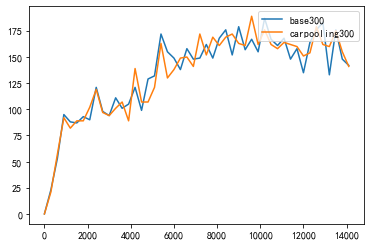

In [192]:
'''时间段累计完成的订单数'''
import sumolib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
def over_order_count(file,step):
    tree=ET.parse(f'{file}\\sumo_outputs\\tripinfos.xml')
    root=tree.getroot()
    personinfos=root.findall('personinfo')
    over_count=0
    over_list=[]
    def count_order(nowtime):
        count=0  
        for personinfo in personinfos:
            if personinfo.findall('ride'): 
                for ride in personinfo.findall('ride'):
                    if float(ride.get('arrival'))>=nowtime and float(ride.get('arrival'))<(nowtime+step):
                        count+=1
        # over_count+=count
        return count
    # count_order(700)
    unover_order_count=[count_order(i) for i in range(0,14400,step)]
    # for i in range(0,14400,step):
    #     over_count+=count_order(i)
    #     over_list.append(over_count)
        
    plt.plot(range(0,14400,step),unover_order_count)
over_order_count('base300',5*60)
over_order_count('carpooling300',5*60)
plt.legend(('base300', 'carpooling300'), loc='upper right') 
# plt.title('Masked line demo')  
plt.show()

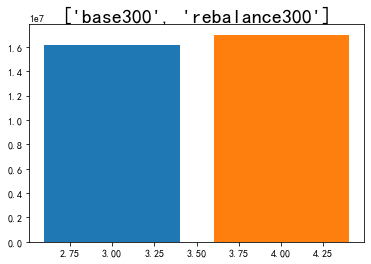

In [67]:
'''总路由长度对比'''
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
def all_route_length(file):
    root=ET.parse(f'{file}\\sumo_outputs\\tripinfos.xml').getroot()
    all_length=0
    for tripinfo in root.findall('tripinfo'):
        # if tripinfo.get('depart')=='0':
        #     root.remove(tripinfo)
        # taxi=tripinfo.find('taxi')
        routeLength=tripinfo.get('routeLength')
        routeLength=float(routeLength)
        all_length+=routeLength
    return all_length
fig,ax=plt.subplots(1,1)
# plt.figure(figsize=(10,5))
# ax.figure.set_size_inches(10,5)
ax.text(0.5,1,['base300','rebalance300'],fontsize=20,horizontalalignment='center',verticalalignment='bottom',transform=ax.transAxes)
y=all_route_length('base300')-1800000
x=3
plt.bar(x,y,)
y=all_route_length('rebalance300')-1800000
x=4
plt.bar(x,y)
plt.show()

In [37]:
'''绘制地图'''
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, HoverTool, ColumnDataSource, LabelSet, Label, Legend, LegendItem
from bokeh.tile_providers import STAMEN_TERRAIN
import pandas as pd

# output_notebook()
# -8234777.628492145 -8239601.654172893 4974363.208545398 4968483.312322854
y_range=(4967000,4976000)
temp=int(((y_range[1]-y_range[0])/2)*1.2)
x_range=(-8237189+temp,-8237189-temp)
# MANHAUS = x_range, y_range = ((-8242000,-8210000), (4963000,4990000))
plot_width  = int(800)
plot_height = int(plot_width//1.2)

options = dict(line_color=None, fill_color='blue', size=5)
# Reusable function to create simple Bokeh plots

def base_plot(tools='pan,wheel_zoom,reset', plot_width=plot_width, plot_height=plot_height, **plot_kwargs):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_kwargs)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p

df5=pd.read_csv(r'persondemand0107\24h0107_end.csv')
df5=df5.loc[(df5.pickup_datetime>=17*60*60)&(df5.pickup_datetime<21*60*60)]
# df5.pickup_longitude=df5.pickup_longitude.astype(float)
# df5.pickup_latitude=df5.pickup_latitude.astype(float)

x_pickup=df5.pickup_longitude
y_pickup=df5.pickup_latitude
x_dropoff=df5.dropoff_longitude
y_dropoff=df5.dropoff_latitude

#将经纬度装换为墨卡托坐标
from pyproj import CRS,Transformer
from_crs = CRS.from_epsg(4326)
to_crs = CRS.from_epsg(3857)
transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
x_pickup,y_pickup = transformer.transform(x_pickup, y_pickup)
x_dropoff,y_dropoff = transformer.transform(x_dropoff, y_dropoff)
# print(x3.max(),x3.min(),y3.max(),y3.min())
from bokeh.tile_providers import get_provider, Vendors

p=base_plot(background_fill_color='black', tools='pan,wheel_zoom,reset,save')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN))
# p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
# # (-8242000,-8210000), (4965000,4990000)
options = dict(line_color=None, fill_color='blue', size=5, alpha=1)
p.circle(x=x_pickup,y=y_pickup,**options)


# show(p)
# p=base_plot(background_fill_color='black', tools='pan,wheel_zoom,reset,save')
# p.add_tile(get_provider(Vendors.STAMEN_TERRAIN))
options=dict(line_color=None, fill_color='orangered', size=5, alpha=1)
p.circle(x=x_dropoff,y=y_dropoff,**options)
show(p)

In [7]:
times=5
step=int(len(df5.index)/times+1)
for i in range(times):
    p=base_plot(background_fill_color='black', tools='pan,wheel_zoom,reset')
    p.add_tile(get_provider(Vendors.STAMEN_TERRAIN))
    # print(len(temp))
    options = dict(line_color=None, fill_color='blue', size=5, alpha=1)
    p.circle(x=x_pickup[step*i:step*(i+1)],y=y_pickup[step*i:step*(i+1)],**options)
    options=dict(line_color=None, fill_color='orangered', size=5, alpha=1)
    p.circle(x=x_dropoff[step*i:step*(i+1)],y=y_dropoff[step*i:step*(i+1)],**options)
    show(p)
# len(data)

In [4]:
'''绘制任意时段的订单数量地图'''
import datetime
import pandas as pd
data=pd.read_csv('persondemand/24hour_end.csv')
def freetime_plot(data,starttime,endtime):
    # basetime=datetime.datetime.strptime('0:00:00','%H:%M:%S')
    h,m,s=map(int,starttime.split(':'))
    starttime=datetime.timedelta(hours=h,minutes=m,seconds=s)
    h,m,s=map(int,endtime.split(':'))
    endtime=datetime.timedelta(hours=h,minutes=m,seconds=s)
    df6=data[(data.pickup_datetime>=starttime.total_seconds())&(data.pickup_datetime<endtime.total_seconds())]
    # print(starttime,endtime)
    '''绘制地图'''
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import BoxZoomTool
    from bokeh.tile_providers import STAMEN_TERRAIN
    import pandas as pd

    output_notebook()
    # -8234777.628492145 -8239601.654172893 4974363.208545398 4968483.312322854
    y_range=(4967000,4976000)
    temp=int(((y_range[1]-y_range[0])/2)*1.2)
    x_range=(-8237189+temp,-8237189-temp)
    # MANHAUS = x_range, y_range = ((-8242000,-8210000), (4963000,4990000))
    plot_width  = int(800)
    plot_height = int(plot_width//1.2)

    options = dict(line_color=None, fill_color='blue', size=5)
    # Reusable function to create simple Bokeh plots

    def base_plot(tools='pan,wheel_zoom,reset', plot_width=plot_width, plot_height=plot_height, **plot_kwargs):
        p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
            x_range=x_range, y_range=y_range, outline_line_color=None,
            min_border=0, min_border_left=0, min_border_right=0,
            min_border_top=0, min_border_bottom=0, **plot_kwargs)
        
        p.axis.visible = False
        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None
        
        p.add_tools(BoxZoomTool(match_aspect=True))
        
        return p


    x_pickup=df6.pickup_longitude
    y_pickup=df6.pickup_latitude
    x_dropoff=df6.dropoff_longitude
    y_dropoff=df6.dropoff_latitude

    #将经纬度装换为墨卡托坐标
    from pyproj import CRS,Transformer
    from_crs = CRS.from_epsg(4326)
    to_crs = CRS.from_epsg(3857)
    transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    x_pickup,y_pickup = transformer.transform(x_pickup, y_pickup)
    x_dropoff,y_dropoff = transformer.transform(x_dropoff, y_dropoff)
    # print(x3.max(),x3.min(),y3.max(),y3.min())
    from bokeh.tile_providers import get_provider, Vendors

    p=base_plot(background_fill_color='black', tools='pan,wheel_zoom,reset')
    p.add_tile(get_provider(Vendors.STAMEN_TERRAIN))
    options = dict(line_color=None, fill_color='blue', size=5, alpha=1)
    p.circle(x=x_pickup,y=y_pickup,**options)
    options=dict(line_color=None, fill_color='orangered', size=5, alpha=1)
    p.circle(x=x_dropoff,y=y_dropoff,**options)
    
    show(p)
freetime_plot(data,'17:00:00','18:00:00')


Loading BokehJS ...

In [48]:
'''不同区域订单绘图'''
data=pd.read_csv(r'persondemand0107\24hour_end_with_id.csv')
def free_region_plot(pickid,dropid):
    
    df=data.loc[data.pickup_id.isin(pickid) & data.dropoff_id.isin(dropid)]
    freetime_plot(df,'0:00:00','24:00:00')
# region_list=[12,88,87,261,13,209,45,231,125,211,144,148,232,4,79,113,114,249,158]
pickid=[12,88]
dropid=[209]
free_region_plot(pickid,dropid)

Loading BokehJS ...

In [25]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

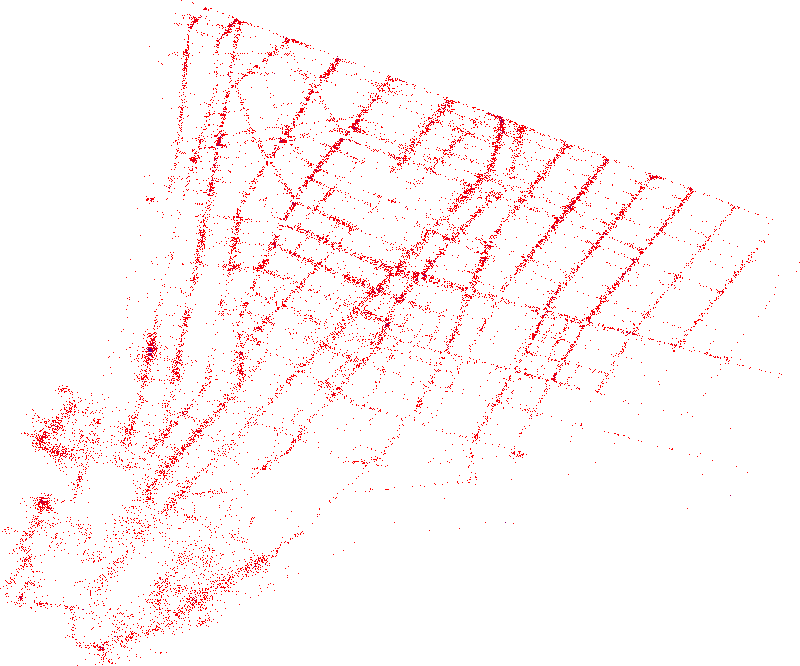

In [26]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
agg = cvs.points(df5, x='pickup_longitude', y='pickup_latitude')
# from matplotlib.cm import hotimport
import datashader.transfer_functions as tf
img=tf.shade(agg, cmap = ["red", 'blue'], how='linear')#pil stands for Python Image Library
img
# agg is an xarray object, see http://xarray.pydata.org/en/stable/coords_lat, coords_lon = agg.coords['latitude'].values, agg.coords['longitude'].values# Corners of the image, which need to be passed to mapboxcoordinates = [[coords_lon[0], coords_lat[0]],               [coords_lon[-1], coords_lat[0]],               [coords_lon[-1], coords_lat[-1]],               [coords_lon[0], coords_lat[-1]]]

In [16]:
# from datashader.bokeh_ext import InteractiveImage,HoverTool
# from functools import partial
# from datashader.utils import export_image
# from datashader.colors import colormap_select, Hot, inferno

# # cool trick (from the offical notebook to make function calls more elegant)
# background = "black"
# export = partial(export_image, export_path="export", background="black")
# cm = partial(colormap_select, reverse=(background=="black"))

# this functions wraps the image creating process of datashader
# def create_image(x_range, y_range, w=plot_width, h=plot_height, **kwargs):
#     cvs = ds.Canvas(plot_width=w, plot_height=h)
#     agg = cvs.points(df5, x='pickup_longitude', y='pickup_latitude')
#     img = tf.shade(agg, cmap=Hot, how='log')
#     return tf.dynspread(img, threshold=0.9, max_px=1)
#     # we can now use bokeh to interactivly create new datashader images at different scales 
# p = base_plot(background_fill_color=background)
# InteractiveImage(p, create_image)

In [33]:
from datashader.bokeh_ext import InteractiveImage,HoverTool
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Hot, inferno

# cool trick (from the offical notebook to make function calls more elegant)
background = "black"
export = partial(export_image, export_path="export", background="white")
cm = partial(colormap_select, reverse=(background=="black"))

# this functions wraps the image creating process of datashader
def create_image(x_range, y_range, w=plot_width, h=plot_height, **kwargs):
    cvs = ds.Canvas(plot_width=w, plot_height=h)
    pick = cvs.points(df5, x='pickup_longitude', y='pickup_latitude')
    drop=cvs.points(df5, x='dropoff_longitude', y='dropoff_latitude')
    # ["darkred", 'orangered']
    # ["darkblue", 'cornflowerblue']
    more_pick = tf.shade(pick, cmap=["darkblue", 'cornflowerblue'], how='log')
    more_drop = tf.shade(drop, cmap=["darkred", 'orangered'], how='log')
    img=tf.stack(more_pick, more_drop)
    return tf.dynspread(img, threshold=0.8, max_px=1)
    # we can now use bokeh to interactivly create new datashader images at different scales 
p = base_plot(background_fill_color='black')
InteractiveImage(p, create_image)

C:\Users\13392\AppData\Roaming\Python\Python39\site-packages\datashader\bokeh_ext.py:233: VisibleDeprecationWarning: InteractiveImage has been deprecated as of datashader 0.8.0. It is not supported in JupyterLab and Bokeh server environments. Please use the HoloViews datashader integration instead.
  warnings.warn('InteractiveImage has been deprecated as of datashader 0.8.0. '


65 0.315588371905379 0.7026319503050067
68 0.3201733936378246 0.7710311042319843
62 0.31726029671203954 0.805062824659946


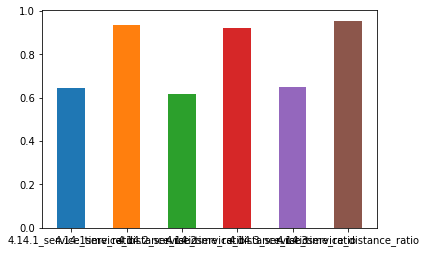

In [16]:
'''车辆的服务路程、时间比，空闲车辆数'''
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
def service_ratio(file):
    tree=ET.parse(f'{file}/sumo_outputs/tripinfos.xml')
    root=tree.getroot()
    count=0
    service_time_ratio=[]
    service_distance_ratio=[]
    for tripinfos in root.findall('tripinfo'):
        # tripinfos.get('id')
        customers=tripinfos.find('taxi').get('customers')
        if float(customers)==0.:
            count=count+1
        else:
            service_time_ratio.append(float(tripinfos.find('taxi').get('occupiedTime'))/float(tripinfos.get('duration')))
            service_distance_ratio.append(float(tripinfos.find('taxi').get('occupiedDistance'))/float(tripinfos.get('routeLength')))
    print(count,np.mean(service_time_ratio),np.mean(service_distance_ratio))
    plt.bar(x=f'{file}_service_time_ratio',height=service_time_ratio,width=0.5)
    plt.bar(x=f'{file}service_distance_ratio',height=service_distance_ratio,width=0.5)
service_ratio('4.14.1')
service_ratio('4.14.2')
service_ratio('4.14.3')

In [ ]:
'''车辆服务时间'''

D:\Python\Python39\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()
D:\Python\Python39\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()


<Figure size 720x720 with 0 Axes>

D:\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


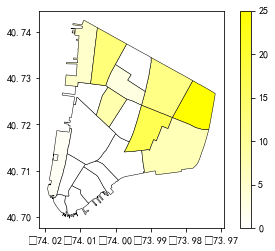

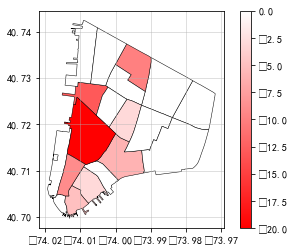

In [26]:
'''不同区域的供需差异图'''
import matplotlib.pyplot as plt
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import geopandas as gpd
data = gpd.read_file('taxi_zones/taxi_zones.shp')
# data.head()
region_list=[12,88,87,261,13,209,45,231,125,211,144,148,232,4,79,113,114,249,158]
data=data.loc[data.LocationID.isin(region_list)]
# dataWGS84 = data.to_crs('EPSG:4326')
# df=data.copy()
df = data.to_crs('EPSG:4326')
from matplotlib import colors
import xml.etree.ElementTree as ET
def plot_diff(file,time):
    tree=ET.parse(f'{file}\\mylogs\\each_region_demand_supply_aggregate.xml')
    root=tree.getroot()
    region_list=[12,88,87,261,13,209,45,231,125,211,144,148,232,4,79,113,114,249,158]
    region_list.sort()
    for regiondemandsupply in root.findall('regiondemandsupply'):
        temp_dict_p={}
        temp_dict_d={}
        # diff=[]
        # print(regiondemandsupply.get('startTime'),regiondemandsupply.get('timeSpan'))
        for region in regiondemandsupply.findall('region'):
            if float(region.get('supply'))-float(region.get('demand'))>0:
                temp_dict_p[int(region.get('id'))]=float(region.get('supply'))-float(region.get('demand'))
            else:
                temp_dict_d[int(region.get('id'))]=float(region.get('supply'))-float(region.get('demand'))
            # print(region.get('id'),region.get('demand'),region.get('supply'))
        diff=[]
        for i in region_list:
            try:
                diff.append(temp_dict_p[i])
            except:
                diff.append(0)
        df[f'1_{regiondemandsupply.get("startTime")}']=diff
        diff=[]
        for i in region_list:
            try:
                diff.append(temp_dict_d[i])
            except:
                diff.append(0)
        df[f'2_{regiondemandsupply.get("startTime")}']=diff
        # print(temp_dict)
    # del data,region_list,temp_dict,diff,tree,root,regiondemandsupply,region,i
    plt.figure(figsize=(10,10))
    # cdict = ['#4169E1','#FFFF00','#DAA520','#FF0000','#FF00EE','#FF00FF']
    # my_cmap = colors.ListedColormap(cdict,'indexed')
    cmap = colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'), (1, 'yellow')])
    fig, ax = plt.subplots(1, 1)
    
    df.plot(column=f'1_{time}.0', ax=ax, legend=True,alpha=1,edgecolor='k',linewidth=0.5,cmap=cmap)
    fig, ax = plt.subplots(1, 1)
    cmap = colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'red'), (1, 'white')])
    df.plot(column=f'2_{time}.0', ax=ax, legend=True,alpha=1,edgecolor='k',linewidth=0.5,cmap=cmap)
    # df.plot(ax=plt.subplot(1,1,1),alpha=1,edgecolor='k',linewidth=0.5,legend=True,scheme='FisherJenks',column='1_1200.0',
    #         cmap='Reds',)
    # df.plot(ax=plt.subplot(1,1,1),alpha=1,edgecolor='k',linewidth=0.5,legend=True,scheme='FisherJenks',column='2_1200.0',
    #         cmap='Reds',)
    #pip install mapclassify
    # del df
    plt.grid(True,alpha=0.5)
    plt.show()
plot_diff('rebalance300',18*600)

In [ ]:
# '''不同区域的供需差异图'''
# import matplotlib.pyplot as plt
# import numpy as np
# # from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
# import numpy as np
# import geopandas as gpd
# data = gpd.read_file('taxi_zones/taxi_zones.shp')
# # data.head()
# region_list=[12,88,87,261,13,209,45,231,125,211,144,148,232,4,79,113,114,249,158]
# data=data.loc[data.LocationID.isin(region_list)]
# # dataWGS84 = data.to_crs('EPSG:4326')
# # df=data.copy()
# df = data.to_crs('EPSG:4326')
# temp=np.random.random(19)*100
# df['temp']=temp
# plt.figure(figsize=(10,10))
# df.plot(ax=plt.subplot(1,1,1),alpha=1,edgecolor='k',linewidth=0.5,legend=True,scheme='FisherJenks',column='temp',cmap='Reds')
# #pip install mapclassify
# # del data,df
# plt.grid(True,alpha=0.5)

In [18]:
# from bokeh.io import show
# from bokeh.models import ColumnDataSource
# from bokeh.plotting import figure


# longitude  = [44.990961]
# latitude = [41.552164]

# source = ColumnDataSource(data=dict(longitude=longitude, latitude=latitude))

# p = figure(plot_width=400, plot_height=400)
# p.circle(x='longitude', y='latitude', source=source)
# show(p)

In [19]:
# import pandas as pd
# data=pd.read_csv('edge_end.csv')
# data['pickup_datetime']=data['pickup_datetime']-3600
# data=data.loc[data['pickup_datetime']>=0]
# data.to_csv('edge_end_1.csv',index=False)

In [20]:
# import xml.etree.ElementTree as ET
# tree = ET.parse("convert-1-personDemandtrips.xml")  # 将xml解析为树
# root = tree.getroot()
# # person=root.findall('person')
# for person in root.findall('person'):
#     depart=person.attrib['depart']
#     id=person.attrib['id']
#     depart=str(int(depart)-3600)
#     id=str(int(id)-2345)
#     person.set('depart',depart)
#     person.set('id',id)
#     # print(depart)
# tree.write('kun.xml', 'UTF-8')

In [4]:
# import pandas as pd
# import xml.etree.ElementTree as ET
# import datetime
# StartTime='17:00:00'
# EndTime='18:00:00'
# # EndTime=datetime.datetime.strptime(EndTime,'%H:%M:%S')
# h,m,s=map(int,EndTime.split(':'))

# EndTime=datetime.timedelta(hours=h,minutes=m,seconds=s)
# # StartTime=datetime.datetime.strptime(StartTime,'%H:%M:%S')
# h,m,s=map(int,StartTime.split(':'))
# StartTime=datetime.timedelta(hours=h,minutes=m,seconds=s)
# # BaseTime=datetime.datetime.strptime('00:00:00','%H:%M:%S')
# SpanTime=EndTime-StartTime
# print(SpanTime.total_seconds())
# StartTime.total_seconds()
# EndTime.total_seconds()


3600.0


64800.0

In [49]:
# tree=ET.parse(r'persondemand\convert-1-personDemandtrips.xml')
# root=tree.getroot()
# with open(r'a.xml','w') as f:
#     f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
#     f.write('<routes>\n\t')
#     for person in root.findall('person'):
#         depart=person.attrib['depart']
#         # id=person.attrib['id']
#         depart=str(int(depart)-int(StartTime.total_seconds()))
#         person.set('depart',depart)
#         if int(person.attrib['depart'])<0:
#             id_0=person.attrib['id']
#         else:
#             id=person.attrib['id']
#             id=str(int(id)-int(id_0)-1)
#             person.set('id',id)
#             f.write(ET.tostring(person,encoding='utf-8').decode('utf-8'))

#     f.write('</routes>')

In [9]:
# data=pd.read_csv('persondemand/24hour_end.csv')
# data.pickup_datetime=data.pickup_datetime-int(StartTime.total_seconds())
# data=data.loc[data['pickup_datetime']>=0]
# data.to_csv('persondemand/24hour_end_1.csv',index=False)

In [1]:
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point
# data=pd.read_csv(r'persondemand0107\24h0107_end.csv')
# region_list=[12,88,87,261,13,209,45,231,125,211,144,148,232,4,79,113,114,249,158]
# geodata = gpd.read_file('taxi_zones/taxi_zones.shp')
# geodata=geodata.loc[geodata.borough=='Manhattan']
# geodata=geodata.loc[geodata.LocationID.isin(region_list)]
# dataWGS84 = geodata.to_crs('EPSG:4326')
# point_list=[Point(data.pickup_longitude[i],data.pickup_latitude[i])  for i in data.index.values]   
# id_list=[dataWGS84.contains(i)[dataWGS84.contains(i) == True].index[0]+1 for i in point_list]
# point_list=[Point(data.dropoff_longitude[i],data.dropoff_latitude[i])  for i in data.index.values]   
# dropoff_id_list=[dataWGS84.contains(i)[dataWGS84.contains(i) == True].index[0]+1 for i in point_list]
# data['pickup_id']=id_list
# data['dropoff_id']=dropoff_id_list
# data.to_csv('persondemand0107/24hour_end_with_id.csv',index=0)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.transforms import Affine2D
# def get_transform_2pts(q1, q2, p1, p2):
# # """ create transform to transform from q to p,such that q1 will point to p1, and q2 to p2 """
#     ang = np.arctan((p2-p1)[1] /(p2-p1)[0])-np.arctan((q2-q1)[1] /(q2-q1)[0])
#     s = np.abs(np.sqrt(np.sum((p2-p1)**2))/np.sqrt(np.sum((q2-q1)**2)))
#     trans = Affine2D().translate(*-q1).rotate(ang).scale(s).translate(*p1)
#     return trans
# image = plt.imread(r"C:\Users\13392\Downloads\中国地图小.png")
# y0 = image.shape[0]
# waypoints = [[0, -1, -4, -6, -6], [0, 0, 4, 4, 3]]
# # Coordinates for transformation.
# lc1 = np.array([0,0])
# ic1 = np.array([475, y0-187])
# lc2 = np.array([-1, 0])
# ic2 = np.array([437, y0-194])
# trans = get_transform_2pts(lc1, lc2, ic1, ic2)
# fig, ax = plt.subplots()
# ax.imshow(np.flipud(image), origin="lower")
# plt.plot(waypoints[0], waypoints[1], 'o-', transform=trans+ax.transData)
# # ax.set_aspect("equal")
# plt.show()

In [41]:
'''绘制地图'''
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, HoverTool, ColumnDataSource, LabelSet, Label, Legend, LegendItem
from bokeh.tile_providers import STAMEN_TERRAIN
import pandas as pd

output_notebook()
# -8234777.628492145 -8239601.654172893 4974363.208545398 4968483.312322854
y_range=(4967000,4976000)
temp=int(((y_range[1]-y_range[0])/2)*1.2)
x_range=(-8237189+temp,-8237189-temp)
# MANHAUS = x_range, y_range = ((-8242000,-8210000), (4963000,4990000))
plot_width  = int(800)
plot_height = int(plot_width//1.2)

options = dict(line_color=None, fill_color='blue', size=5)
# Reusable function to create simple Bokeh plots

def base_plot(tools='pan,wheel_zoom,reset', plot_width=plot_width, plot_height=plot_height, **plot_kwargs):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_kwargs)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p

df5=pd.read_csv('edge_end_1.csv')
# df5.pickup_longitude=df5.pickup_longitude.astype(float)
# df5.pickup_latitude=df5.pickup_latitude.astype(float)

x_pickup=df5.pickup_longitude
y_pickup=df5.pickup_latitude
x_dropoff=df5.dropoff_longitude
y_dropoff=df5.dropoff_latitude

#将经纬度装换为墨卡托坐标
from pyproj import CRS,Transformer
from_crs = CRS.from_epsg(4326)
to_crs = CRS.from_epsg(3857)
transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
x_pickup,y_pickup = transformer.transform(x_pickup, y_pickup)
x_dropoff,y_dropoff = transformer.transform(x_dropoff, y_dropoff)
# print(x3.max(),x3.min(),y3.max(),y3.min())
from bokeh.tile_providers import get_provider, Vendors

p=base_plot(background_fill_color='black', tools='pan,wheel_zoom,reset,save')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN))
# p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
# # (-8242000,-8210000), (4965000,4990000)
options = dict(line_color=None, fill_color='blue', size=5, alpha=1)
p.circle(x=x_pickup,y=y_pickup,**options)
options=dict(line_color=None, fill_color='orangered', size=5, alpha=1)
p.circle(x=x_dropoff,y=y_dropoff,**options)
xs=list(zip(x_pickup,x_dropoff))
ys=list(zip(y_pickup,y_dropoff))
p.multi_line(xs=xs[0:10],ys=ys[0:10],color='orangered')
# p.plot(waypoints[0], waypoints[1], 'o-', transform=trans+ax.transData)
show(p)

Loading BokehJS ...

In [ ]:
# from bokeh.io import output_file, show
# from bokeh.models import ColumnDataSource
# from bokeh.plotting import figure
# from bokeh.transform import linear_cmap

# output_file("cmap.html")

# p = figure()

# source = ColumnDataSource(data=dict(
#     xs=[[0,1] for i in range(256)],     # x coords for each line (list of lists)
#     ys=[[i, i+10] for i in range(256)], # y coords for each line (list of lists)
#     foo=list(range(256))                # data to use for colormapping
# ))

# p.multi_line('xs', 'ys', source=source,
#              color=linear_cmap('foo', "Viridis256", 0, 255))

# show(p)

In [1]:
'''拼车效果图（地图|连线）'''
import xml.etree.ElementTree as ET
tree = ET.parse(r'carpooling300\sumo_outputs\vehroute.rou.xml')
root = tree.getroot()
# vehicle_list=[]
vehicle_dict={}
all_list=[]
for vehicle in root.findall('vehicle'):
    actType_str=''
    actType_list=[]
    x_list=[]
    permitted_list=[]
    person_list=[]
    for stop in vehicle.findall('stop'):
        try:
            actType=(stop.attrib['actType']).split(' ')[0]
            person=(stop.attrib['actType']).split(' ')[1]
            # actType_str+=actType
            actType_list.append(actType)
            permitted_list.append(person)
            # print(actType,person)
        except:
            continue
    for x,i in enumerate(actType_list):
        try:
            if i==actType_list[x+1]:
                person_list=permitted_list[x:]
                # x_list.append((x-1)//2)
                all_list.append(person_list)
                break
                # vehicle_list.append(vehicle.attrib['id'])
        except:
            continue
# all_list
import pandas as pd
from collections import Counter 
df=pd.read_csv(r'carpooling300\sumo_outputs\tripinfos.csv')
df=df.dropna(axis=0,subset=['ride_depart'])
df=df.loc[df.ride_depart!=-1]
person_list=[]
for i in range(4200,4201):
    df1=df.loc[(df['ride_depart']<=i) & (df['ride_arrival']>i)]
    # print('personinfo_id')
    a=df1['ride_vehicle'].values
    # print(a)
    b = dict(Counter(a))
    c={key:value for key,value in b.items()if value > 1}  #只展示重复元素
    if c != {}:
        # print(c)
        for j in c.keys():
            df2=df1.loc[df1['ride_vehicle']==j]
            temp=list(df2.personinfo_id.values.astype(int))
            temp.sort()
            if temp not in person_list:
                person_list.append(temp)
                del temp
            # person_list.append(df2.personinfo_id.values)
# person_list
id_list=[]
for i in person_list:
    for j in i:
        id_list.append(j)
# id_list
i_list=[]
for i in all_list:
    j_list=[]
    for j in i:
        j=int(j)
        if j in id_list:
            j_list.append(j)
    if j_list!=[] and len(j_list)>3:
        i_list.append(j_list)
# i_list
# all_list


In [201]:
# import pandas as pd
# data=pd.read_csv(r'24hour_end_1.csv')
# data['id']=data.index
# # data.loc[data.id==10].pickup_longitude.values[0]
# # a.values[0]
# data.to_csv(r'24hour_end_1.csv',index=False)

In [2]:
df5=pd.read_csv('24hour_end_1.csv')

# df5=df5.loc[df5.id.isin(id_list)]

x_pickup=df5.pickup_longitude
y_pickup=df5.pickup_latitude
x_dropoff=df5.dropoff_longitude
y_dropoff=df5.dropoff_latitude
#将经纬度装换为墨卡托坐标
from pyproj import CRS,Transformer
from_crs = CRS.from_epsg(4326)
to_crs = CRS.from_epsg(3857)
transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
x_pickup,y_pickup = transformer.transform(x_pickup, y_pickup)
x_dropoff,y_dropoff = transformer.transform(x_dropoff, y_dropoff)
# print(x3.max(),x3.min(),y3.max(),y3.min())
df5['x_pickup']=x_pickup
df5['y_pickup']=y_pickup
df5['x_dropoff']=x_dropoff
df5['y_dropoff']=y_dropoff

xx_list=[]
yy_list=[]
for i in i_list:
    temp_list=[]
    x_list=[]
    y_list=[]
    for j in i:
        j=int(j)
        if temp_list.count(j)==0:
            x_list.append(df5.loc[df5.id==j].x_pickup.values[0])
            y_list.append(df5.loc[df5.id==j].y_pickup.values[0])
            temp_list.append(j)
        else:
            x_list.append(df5.loc[df5.id==j].x_dropoff.values[0])
            y_list.append(df5.loc[df5.id==j].y_dropoff.values[0])
            temp_list.append(j)
    xx_list.append(tuple(x_list))
    yy_list.append(tuple(y_list))
    # xx_list.append(x_list)
# xx_list


In [4]:
'''绘制地图'''
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, HoverTool, ColumnDataSource, LabelSet, Label, Legend, LegendItem
from bokeh.tile_providers import STAMEN_TERRAIN
import pandas as pd
df5=df5.loc[df5.id.isin(id_list)]
x_pickup=df5.x_pickup
y_pickup=df5.y_pickup
x_dropoff=df5.x_dropoff
y_dropoff=df5.y_dropoff

output_notebook()
# -8234777.628492145 -8239601.654172893 4974363.208545398 4968483.312322854
y_range=(4967000,4976000)
temp=int(((y_range[1]-y_range[0])/2)*1.2)
x_range=(-8237189+temp,-8237189-temp)
# MANHAUS = x_range, y_range = ((-8242000,-8210000), (4963000,4990000))
plot_width  = int(800)
plot_height = int(plot_width//1.2)

options = dict(line_color=None, fill_color='blue', size=5)
# Reusable function to create simple Bokeh plots

def base_plot(tools='pan,wheel_zoom,reset', plot_width=plot_width, plot_height=plot_height, **plot_kwargs):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_kwargs)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p

from bokeh.tile_providers import get_provider, Vendors

p=base_plot(background_fill_color='black', tools='pan,wheel_zoom,reset,save')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN))
# p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
# # (-8242000,-8210000), (4965000,4990000)
options = dict(line_color=None, fill_color='blue', size=5, alpha=1)
p.circle(x=x_pickup,y=y_pickup,**options)
options=dict(line_color=None, fill_color='orangered', size=5, alpha=1)
p.circle(x=x_dropoff,y=y_dropoff,**options)
# for i in person_list:
#     for j in i:
        
# xs=list(zip(x_pickup,x_dropoff))
# ys=list(zip(y_pickup,y_dropoff))
xs=xx_list
ys=yy_list
p.multi_line(xs=xs,ys=ys,color='orangered')
# p.plot(waypoints[0], waypoints[1], 'o-', transform=trans+ax.transData)
show(p)

Loading BokehJS ...

In [74]:
'''最大乘客载量的拼车影响'''
import pandas as pd
from collections import Counter 
df=pd.read_csv(r'carpooling300-10\sumo_outputs\tripinfos.csv')

df=df.dropna(axis=0,subset=['ride_depart'])
df=df.loc[df.ride_depart!=-1]
person_list=[]
all_num=(4800-3600)*150/5
one_num=0
two_num=0
three_num=0
four_num=0
five_num=0
six_num=0
seven_num=0
eight_num=0
nine_num=0
ten_num=0
for i in range(7200,7800,5):
    df1=df.loc[(df['ride_depart']<=i) & (df['ride_arrival']>i)]
    # print('personinfo_id')
    a=df1['ride_vehicle'].values
    # print(a)
    b = dict(Counter(a))
    d_1={key:value for key,value in b.items()if value == 1}
    # print(len(d))
    one_num+=len(d_1)
    d_2={key:value for key,value in b.items()if value == 2}
    two_num+=len(d_2)
    d_3={key:value for key,value in b.items()if value == 3}
    d_4={key:value for key,value in b.items()if value == 4}
    d_5={key:value for key,value in b.items()if value == 5}
    d_6={key:value for key,value in b.items()if value == 6}
    d_7={key:value for key,value in b.items()if value == 7}
    d_8={key:value for key,value in b.items()if value == 8}
    d_9={key:value for key,value in b.items()if value == 9}
    d_10={key:value for key,value in b.items()if value == 10}
    three_num+=len(d_3)
    four_num+=len(d_4)
    five_num+=len(d_5)
    six_num+=len(d_6)
    seven_num+=len(d_7)
    eight_num+=len(d_8)
    nine_num+=len(d_9)
    ten_num+=len(d_10)
    c={key:value for key,value in b.items()if value > 1}  #只展示重复元素
    if c != {}:
        # print(c)
        for j in c.keys():
            df2=df1.loc[df1['ride_vehicle']==j]
            temp=list(df2.personinfo_id.values.astype(int))
            temp.sort()
            if temp not in person_list:
                person_list.append(temp)
                del temp
            # person_list.append(df2.personinfo_id.values)
# person_list

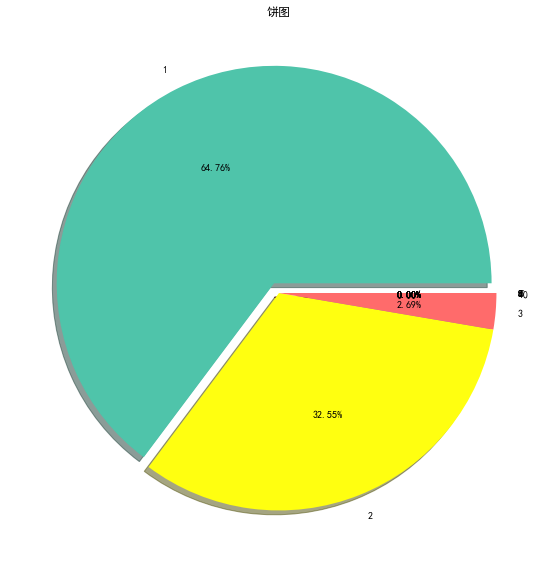

In [76]:
# 饼图
import matplotlib.pyplot as plt
null=all_num-one_num-len(person_list)
data = {
    # '0': (null, '#7199cf'),
    '1': (one_num, '#4fc4aa'),
    '2': (two_num, '#ffff10'),
    '3': (three_num, '#ff6b6b'),
    '4': (four_num, '#ff0000'),
    '5': (five_num, '#ff1b6b'),
    '6': (six_num, '#ff686b'),
    '7': (seven_num, '#f46b6b'),
    '8': (eight_num, '#f66b6b'),
    '9': (nine_num, '#ff3b6b'),
    '10': (ten_num, '#f15b6b'),
}
# 设置绘图对象的大小
fig = plt.figure(figsize=(10,10))
cities = data.keys()
values = [x[0] for x in data.values()]
colors = [x[1] for x in data.values()]
ax1 = fig.add_subplot(111)
ax1.set_title('饼图')
labels = ['{}'.format(city) for city, value in zip(cities, values)]

explode = [0.05, 0, 0,0,0,0,0,0,0,0] # 设置饼图的凸出显示
ax1.pie(values, labels=labels, colors=colors, explode=explode, shadow=True,autopct='%.2f%%' ) # 画饼状图， 并且指定标签和对应的颜色  指定阴影效果

# plt.savefig('pie.jpg') # 保存成图片
plt.rcParams['font.sans-serif']=['SimHei']  # 中文
plt.show()

In [ ]:
# from collections import Counter   #引入Counter
# a = [29,36,57,12,79,43,23,56,28,11,14,15,16,37,24,35,17,24,33,15,39,46,52,13]
# b = dict(Counter(a))
# print ([key for key,value in b.items()if value > 1])  #只展示重复元素
# print ({key:value for key,value in b.items()if value > 1})  #展现重复元素和重复次数

In [81]:
'''做一个  拼车与没有拼车的图形对比
出租车数量增加的模拟结果   
normal 与 share  平均等待时间，平均路由长度
100 150 200 250 300'''
import xml.etree.ElementTree as ET
import json
def getmean(file):
    with open(f'{file}\\settings\\parameters.json','r') as fp:
        str = fp.read()
        data = json.loads(str)
    # print(data)
    tree = ET.parse(f'{file}\\sumo_outputs\\tripinfos.xml')
    root = tree.getroot()
    #平均等待时间
    wating_time_list=[]
    # routelength_list=[]
    for personinfo in root.findall('personinfo'):
        ride=personinfo.find('ride')
        if ride is not None:
            if ride.get('depart')!='-1' :
                wating_time_list.append(float(ride.get('waitingTime')))
                # routelength_list.append(float(ride.get('routeLength')))
    waiting_time_mean=sum(wating_time_list)/len(wating_time_list)
    #平均路由长度
    routelength_list=[]
    for tripinfo in root.findall('tripinfo'):
        routelength_list.append(float(tripinfo.get('routeLength')))   
    routelength_mean=sum(routelength_list)/len(routelength_list)
    data['waiting_time_mean']=waiting_time_mean
    data['routelength_mean']=routelength_mean
    return data
# waiting_time_mean,routelength_mean=getmean('4.18.1')
# print(waiting_time_mean,routelength_mean)
data1=getmean('base150')
data2=getmean('base200')
data3=getmean('base250')
data4=getmean('base300')
data5=getmean('base350')
# data6=getmean('carpooling150')
data7=getmean('carpooling200')
data8=getmean('carpooling250')
data9=getmean('carpooling300')
data10=getmean('carpooling350')

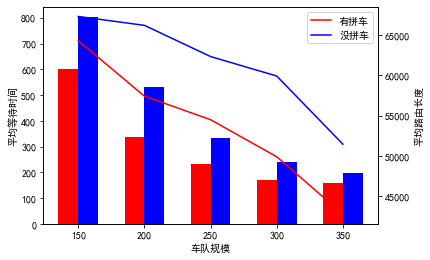

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为微软雅黑

# 定义房价
base_length = [ data1['routelength_mean'], data2['routelength_mean'], data3['routelength_mean'],
         data4['routelength_mean'],  data5['routelength_mean']]
carpooling_length = [data1['routelength_mean']-3000, data7['routelength_mean'], data8['routelength_mean'],
         data9['routelength_mean'],  data10['routelength_mean']]
# 定义成交量
# total = [100, 50, 40, 60, 120]
# 定义车队规模
FleetSize = [100,150, 200, 250, 300]
fig, ax = plt.subplots(1, 1)

base_time= [data1['waiting_time_mean'],data2['waiting_time_mean'],data3['waiting_time_mean'],
        data4['waiting_time_mean'],data5['waiting_time_mean']]
carpooling_time = [data1['waiting_time_mean']-200,data7['waiting_time_mean'],data8['waiting_time_mean'],
        data9['waiting_time_mean'],data10['waiting_time_mean']]
x = np.arange(5) #总共有几组，就设置成几，我们这里有三组，所以设置为3
total_width, n = 0.6, 2    # n有多少个类型
width = total_width / n
x = x - (total_width - width) / 2
# 共享x轴，生成次坐标轴
ax_sub = ax.twinx()
# 绘图
ax.bar(x, carpooling_time, color = "r",width=width,label='有拼车')
ax.bar(x + width, base_time, color = "b",width=width,label='没拼车')
ax_sub.plot([0,1,2,3,4], carpooling_length, 'r-', label='有拼车')
ax_sub.plot([0,1,2,3,4], base_length, 'b-', label='没拼车')
# ax.bar(FleetSize, total,width=20)
# ax.bar([i+20 for i in FleetSize], total,width=20)
plt.xticks([0,1,2,3,4],['150','200', '250', '300', '350'])
# 放置图例
plt.legend(loc=0)
# 设置主次y轴的title
ax_sub.set_ylabel('平均路由长度')
ax.set_ylabel('平均等待时间')
# 设置x轴title
ax.set_xlabel('车队规模')
# 设置图片title
# ax.set_title('不同规模下是否有拼车的平均等待时间与平均路由长度')
plt.show()


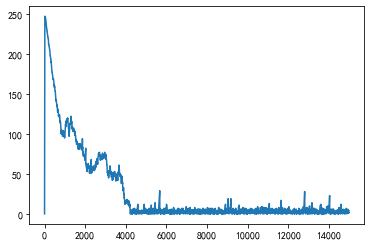

In [22]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
tree=ET.parse(r'base250\mylogs\taxi_stat_num_record.xml')
root=tree.getroot()
time_list=[]
vacant_list=[]
for taxistatnum in root.findall('taxistatnum'):
    # if float(taxistatnum.get('time'))>=1000:
    time_list.append(float(taxistatnum.get('time')))
    vacant_list.append(float(taxistatnum.get('vacantNum')))
        # print(taxistatnum.get('time'),taxistatnum.get('vacantNum'))
plt.plot(time_list,vacant_list)